In [34]:
from __future__ import print_function
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import csv

In [35]:
# load the measured input intensity data from the indicated file path
input_intensity_file_path = r"C:\Users\zxq220007\Box\Quantum Optics Lab\TeTON OANN Testbed\Data 2024\May 22 2024\Input intensity\input_intensity_boxes.txt"
# read the file and store the second element of each row in a numpy array
# skip the first row
input_intensity = np.loadtxt(input_intensity_file_path, delimiter=',', usecols=1, skiprows=1)
# convert the numpy array to a torch tensor
Distr = torch.tensor(input_intensity, dtype=torch.float32)

# load the EIT data


# Reading the parameters from the csv file
csv_file_path = r"C:\Users\zxq220007\Box\Quantum Optics Lab\TeTON OANN Testbed\Data 2024\Apr 16 2024\5X5 Trans5 50mm cell 130C 290MHz 3037MHz\Results 2\Optimized_Curve_Fitting_Parameters.csv"

# Indicating the concavity of the non linear funtion used for curve fitting
# 1: Concave up exponential function
# 2: Concave down exponential function
function_tpye = 1

# Initializing the arrays to store the parameters
a = np.array([])
OD = np.array([])
g = np.array([])

# Reading the csv file
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    # we want to skip the first row in the csv file
    next(csv_reader)  

    for row in csv_reader:
        a = np.append(a, float(row[1]))
        OD = np.append(OD, float(row[2]))
        g = np.append(g, float(row[3]))

# Provided parameter values
# a = np.array([3534100, 3722200, 3852400, 4307000, 3657400, 3141500, 3178200,
#           3960700, 3765900, 4158300, 3463600, 3263600, 4042800, 3859800,
#           3263500, 3321000, 4023600, 3909900, 4442100, 3975800])

# OD = np.array([2.6724, 2.6481, 2.7274, 3.0563, 3.3325, 2.9912, 2.8601, 3.3032,
#           2.6161, 2.5694, 3.2993, 3.3299, 2.4537, 2.3774, 2.42, 2.9881,
#           2.7565, 3.007, 3.1546, 3.063])

# g = np.array([23.072, 25.567, 29.146, 24.402, 27.776, 41.254, 24.124, 20.662,
#           33.321, 25.71, 28.885, 36.446, 26.033, 23.523, 40.512, 38.207,
#           39.111, 29.031, 32.155, 27.549])


C:\Users\zxq220007\AppData\Local\Temp\ipykernel_21088\2049934889.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Distr = torch.tensor(Distr, dtype=torch.float32)


Epoch 1: loss:0.035576
Epoch 1: Accuracy: 3813 / 10000 (38%)

Epoch 1: Error Rate: 61.87%

Epoch 2: loss:0.032560
Epoch 2: Accuracy: 5609 / 10000 (56%)

Epoch 2: Error Rate: 43.91%

Epoch 3: loss:0.027227
Epoch 3: Accuracy: 6382 / 10000 (64%)

Epoch 3: Error Rate: 36.18%

Epoch 4: loss:0.022636
Epoch 4: Accuracy: 7056 / 10000 (71%)

Epoch 4: Error Rate: 29.44%

Epoch 5: loss:0.019351
Epoch 5: Accuracy: 7621 / 10000 (76%)

Epoch 5: Error Rate: 23.79%

Epoch 6: loss:0.017099
Epoch 6: Accuracy: 7774 / 10000 (78%)

Epoch 6: Error Rate: 22.26%

Epoch 7: loss:0.015576
Epoch 7: Accuracy: 7942 / 10000 (79%)

Epoch 7: Error Rate: 20.58%

Epoch 8: loss:0.014463
Epoch 8: Accuracy: 8057 / 10000 (81%)

Epoch 8: Error Rate: 19.43%

Epoch 9: loss:0.013625
Epoch 9: Accuracy: 8146 / 10000 (81%)

Epoch 9: Error Rate: 18.54%

Epoch 10: loss:0.012954
Epoch 10: Accuracy: 8164 / 10000 (82%)

Epoch 10: Error Rate: 18.36%

Epoch 11: loss:0.012401
Epoch 11: Accuracy: 8202 / 10000 (82%)

Epoch 11: Error Rate: 1

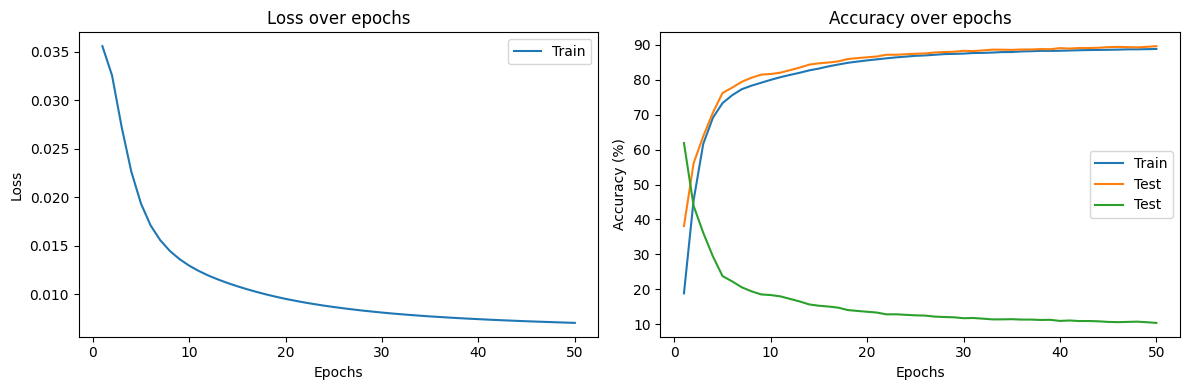

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # initializing all parameters for the nonlinear layer and the linear layers 
        self.fc1 = nn.Parameter(torch.randn(25, 144)* 0.01)   # Better initialization
        self.fc2 = nn.Parameter(torch.randn(10, 25) * 0.1)
        self.a = torch.tensor(a, dtype=torch.float32)
        self.gamma12 = torch.tensor(g, dtype=torch.float32)
        self.OD = torch.tensor(OD, dtype=torch.float32)
        self.Distr = torch.tensor(Distr, dtype=torch.float32)
        
        # sigmoid activation function

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, R):
        # adding the input intensity to the data
        x = x.view(-1, 144)
        x = x * self.Distr.view(-1, 144)
        # first linear layer
        x = F.linear(x, abs(self.fc1))

        # nonlinear layer using data from Ying
        # x = self.a * torch.exp(-12 * self.OD * self.gamma12 / (x * 12800 + self.gamma12 * 12))
        # x = self.a * torch.exp(self.OD * x) + self.gamma12

        # nonlinear layer using sigmoid
        x = self.sigmoid(x)
        # x = self.sigmoid(self.a * torch.exp(self.OD * x) + self.gamma12)
        # x = self.sigmoid(self.a * x + self.gamma12)

        # adding randomness to the last linear 
        rand4 = 1 + torch.randn(10) * R
        out = F.linear(x, abs(self.fc2)) * rand4
        return out

# def confusion_matrix(preds, labels):
#     # calculating the confusion matrix
#     conf_matrix = torch.zeros(10, 10)
#     for p, t in zip(preds, labels):
#         conf_matrix[p, t] += 1
#     return conf_matrix
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    training_loss = 0
    training_accuracy = 0
    correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, 0)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    training_loss /= len(train_loader.dataset)
    training_accuracy = 100. * correct / len(train_loader.dataset)
    
    print('Epoch {}: loss:{:.6f}'.format(epoch, training_loss))

    return training_loss, training_accuracy

def test(model, device, test_loader, epoch):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, 0)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    accuracy = 100. * correct / total
    error_rate = 100. * (total - correct) / total
    print(f'Epoch {epoch}: Accuracy: {correct} / {total} ({accuracy:.0f}%)\n')
    print(f'Epoch {epoch}: Error Rate: {error_rate:.2f}%\n')

    return accuracy, error_rate

def save_weights_to_excel(weights, filename):
    df = pd.DataFrame(abs(weights.cpu().detach().numpy()))
    df.to_excel(filename, index=False)
    
def main():
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")


    # testing for the FashionMNIST dataset, for regular MNIST dataset, use datasets.MNIST instead
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                       ])),
        batch_size=64, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                       ])),
        batch_size=1000, shuffle=True)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

    # Create a learning rate scheduler, adjust the step_size and gamma parameters to change the learning rate schedule
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # adjust this parameter to change the number of epochs
    number_of_epochs = 50

    for epoch in range(1, number_of_epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        test_accuracy = test(model, device, test_loader, epoch)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        test_accuracies.append(test_accuracy) 

        # Step the scheduler
        # scheduler.step()
    
    # print(train_losses)

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, number_of_epochs+1), train_losses, label='Train')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, number_of_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, number_of_epochs + 1), test_accuracies, label='Test')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

    # Save the weight matrices as Excel files
    save_weights_to_excel(model.fc1.data, r"C:\Users\zxq220007\Box\Quantum Optics Lab\TeTON OANN Testbed\Anderson Xu\AONN\Neural Network Training\fc1_weights.xlsx")
    save_weights_to_excel(model.fc2.data, r"C:\Users\zxq220007\Box\Quantum Optics Lab\TeTON OANN Testbed\Anderson Xu\AONN\Neural Network Training\fc2_weights.xlsx")

if __name__ == '__main__':
    main()